In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model



In [2]:
print(tf.__version__)

2.13.0


In [3]:
#!pip install --upgrade tensorflow

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/IACSD_Project_Data/HAR.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Human Action Recognition/train/Image_5499.jpg  
  inflating: Human Action Recognition/train/Image_55.jpg  
  inflating: Human Action Recognition/train/Image_550.jpg  
  inflating: Human Action Recognition/train/Image_5500.jpg  
  inflating: Human Action Recognition/train/Image_5501.jpg  
  inflating: Human Action Recognition/train/Image_5502.jpg  
  inflating: Human Action Recognition/train/Image_5503.jpg  
  inflating: Human Action Recognition/train/Image_5504.jpg  
  inflating: Human Action Recognition/train/Image_5505.jpg  
  inflating: Human Action Recognition/train/Image_5506.jpg  
  inflating: Human Action Recognition/train/Image_5507.jpg  
  inflating: Human Action Recognition/train/Image_5508.jpg  
  inflating: Human Action Recognition/train/Image_5509.jpg  
  inflating: Human Action Recognition/train/Image_551.jpg  
  inflating: Human Action Recognition/train/Image_5510.jpg  
  inflating: Human Action Recognition/

In [6]:
train_csv_path=r'/content/Human Action Recognition/Training_set.csv'
test_csv_path=r'/content/Human Action Recognition/Testing_set.csv'
train_img_path=r'/content/Human Action Recognition/train'
test_img_path=r'/content/Human Action Recognition/test'
df=pd.read_csv(train_csv_path)

df.columns=['filepaths', 'labels']

df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(train_img_path, x))

train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))


max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

ht=0
wt=0

train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  11340   test_df length:  630   valid_df length:  630
The number of classes in the dataset is:  15
            CLASS               IMAGE COUNT 
           calling                  756     
           clapping                 756     
           cycling                  756     
           dancing                  756     
           drinking                 756     
            eating                  756     
           fighting                 756     
           hugging                  756     
           laughing                 756     
      listening_to_music            756     
           running                  756     
           sitting                  756     
           sleeping                 756     
           texting                  756     
         using_laptop               756     
calling  has the most images=  756   calling  has the least images=  756
average height=  198  average width=  258 aspect ratio=  0.7662875270813989


In [7]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=300
min_samples=300
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  300


In [8]:
working_dir=r'/content/Human Action Recognition/'
img_size=(200,260)
batch_size=30
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='')
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='')
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='')
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 4500 validated image filenames belonging to 15 classes.
Found 630 validated image filenames belonging to 15 classes.
Found 630 validated image filenames belonging to 15 classes.
test batch size:  70   test steps:  9  number of classes :  15


In [9]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

Output hidden; open in https://colab.research.google.com to view.

In [10]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, \
                                                 weights="imagenet",input_shape=img_shape, pooling='max')

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 [==============================] - 0s 0us/step


In [11]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch):
        super(ASK, self).__init__()
        self.model=model
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs:
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False
        if self.epochs == 1:
            self.ask=False
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to')
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time= time.time()

    def on_train_end(self, logs=None):
        tr_duration=time.time() - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        if self.ask:
            if epoch + 1 ==self.ask_epoch:
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()

                if ans == 'H' or ans =='h' or ans == '0':
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

In [12]:
epochs=40
ask_epoch=10
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

In [13]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
150/150 [==============================] - 176s 653ms/step - loss: 8.9405 - accuracy: 0.3811 - val_loss: 7.2835 - val_accuracy: 0.6365 - lr: 0.0010
Epoch 2/40
150/150 [==============================] - 97s 643ms/step - loss: 6.4148 - accuracy: 0.6160 - val_loss: 5.5469 - val_accuracy: 0.7206 - lr: 0.0010
Epoch 3/40
150/150 [==============================] - 94s 627ms/step - loss: 4.8948 - accuracy: 0.7089 - val_loss: 4.3091 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 4/40
150/150 [==============================] - 95s 629ms/step - loss: 3.7387 - accuracy: 0.7782 - val_loss: 3.3732 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 5/40
150/150 [==============================] - 96s 638ms/step - loss: 2.8653 - accuracy: 0.8289 - val_loss: 2.7324 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 6/40
150/150 [===========================

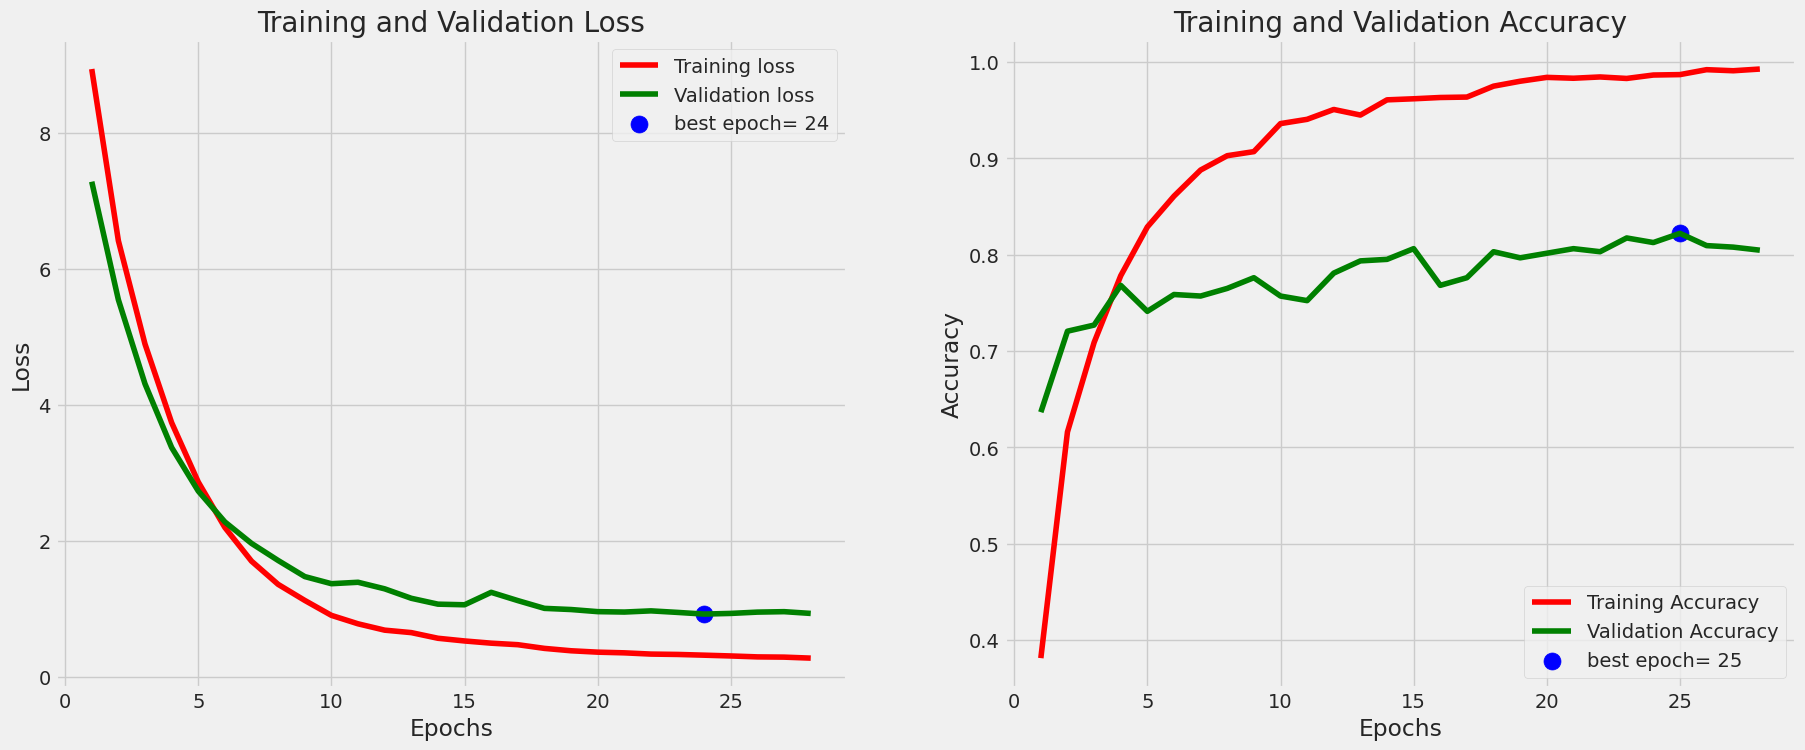

In [14]:
def tr_plot(tr_data, start_epoch):

    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(history,0)

9/9 [==============================] - 6s 218ms/step
there were 121 in 630 tests for an accuracy of  80.79


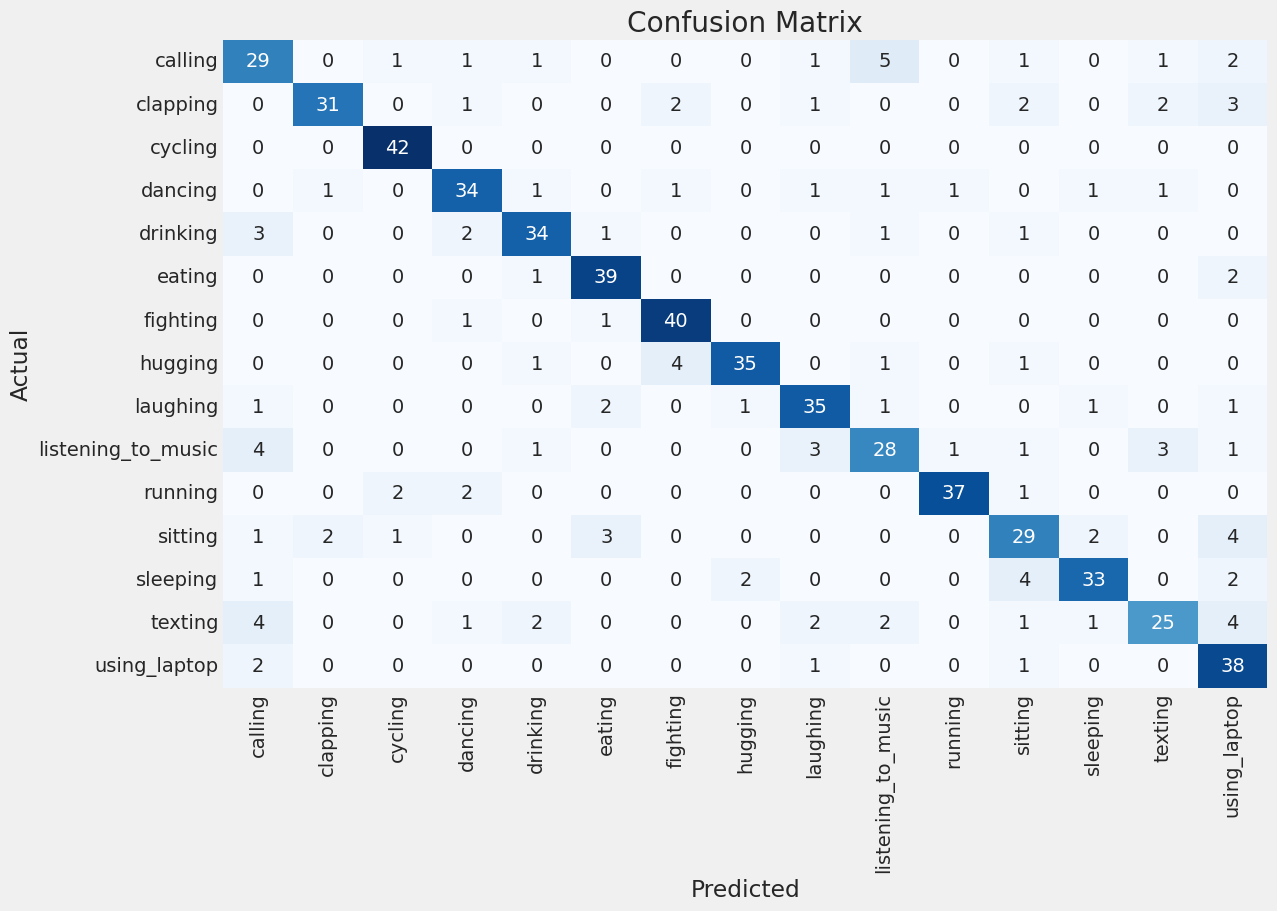

Classification Report:
----------------------
                     precision    recall  f1-score   support

           calling     0.6444    0.6905    0.6667        42
          clapping     0.9118    0.7381    0.8158        42
           cycling     0.9130    1.0000    0.9545        42
           dancing     0.8095    0.8095    0.8095        42
          drinking     0.8293    0.8095    0.8193        42
            eating     0.8478    0.9286    0.8864        42
          fighting     0.8511    0.9524    0.8989        42
           hugging     0.9211    0.8333    0.8750        42
          laughing     0.7955    0.8333    0.8140        42
listening_to_music     0.7179    0.6667    0.6914        42
           running     0.9487    0.8810    0.9136        42
           sitting     0.6905    0.6905    0.6905        42
          sleeping     0.8684    0.7857    0.8250        42
           texting     0.7812    0.5952    0.6757        42
      using_laptop     0.6667    0.9048    0.7677   

In [15]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)
            true_index=test_gen.labels[i]
            if pred_index != true_index:
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4)
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

In [16]:
subject='activities'
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc)+'.h5'
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc )

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model was saved as  /content/Human Action Recognition/activities_80.79.h5


In [17]:
test_csv_path=r'/content/Human Action Recognition/Testing_set.csv'
test_img_path=r'/content/Human Action Recognition/test'
test_df=pd.read_csv(test_csv_path)

test_df.columns=['filepaths']

test_df['filepaths']=test_df['filepaths'].apply(lambda x: os.path.join(test_img_path, x))

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='')
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=None, target_size=img_size,
                                   class_mode=None, color_mode='rgb', shuffle=False, batch_size=test_batch_size)

image_paths=[]
pred_class=[]
preds=model.predict(test_gen, steps=test_steps, verbose=1)

for i, p in enumerate (preds):
    index=np.argmax(p)
    klass=classes[index]
    pred_class.append(klass)
    file=test_gen.filenames[i]
    image_id=os.path.basename(file)
    image_paths.append(image_id)
Fseries=pd.Series(image_paths)
Lseries=pd.Series(pred_class)
submit_df=pd.concat([Fseries, Lseries], axis=1)
submit_df.columns=['filename', 'class']
print(submit_df.head())
submit_path=os.path.join(working_dir, 'submit.csv')
submit_df.to_csv(submit_path,index=False)

check_df=pd.read_csv(submit_path)
print (check_df.head())

Found 5400 validated image filenames.
72/72 [==============================] - 25s 271ms/step
      filename     class
0  Image_1.jpg  sleeping
1  Image_2.jpg    eating
2  Image_3.jpg   running
3  Image_4.jpg    eating
4  Image_5.jpg   texting
      filename     class
0  Image_1.jpg  sleeping
1  Image_2.jpg    eating
2  Image_3.jpg   running
3  Image_4.jpg    eating
4  Image_5.jpg   texting


In [18]:
submit = pd.read_csv('/content/Human Action Recognition/submit.csv')

In [19]:
submit

,filename,class
0,Image_1.jpg,sleeping
1,Image_2.jpg,eating
2,Image_3.jpg,running
3,Image_4.jpg,eating
4,Image_5.jpg,texting
...,...,...
5395,Image_5396.jpg,calling
5396,Image_5397.jpg,fighting
5397,Image_5398.jpg,dancing
5398,Image_5399.jpg,sitting


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten

In [21]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

In [22]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=10
)

Epoch 1/10
150/150 [==============================] - 66s 411ms/step - loss: 3.2663 - accuracy: 0.0816
Epoch 2/10
150/150 [==============================] - 62s 415ms/step - loss: 2.6573 - accuracy: 0.1033
Epoch 3/10
150/150 [==============================] - 64s 424ms/step - loss: 2.5961 - accuracy: 0.1487
Epoch 4/10
150/150 [==============================] - 59s 396ms/step - loss: 2.5683 - accuracy: 0.1527
Epoch 5/10
150/150 [==============================] - 62s 411ms/step - loss: 2.5547 - accuracy: 0.1649
Epoch 6/10
150/150 [==============================] - 65s 430ms/step - loss: 2.5169 - accuracy: 0.1747
Epoch 7/10
150/150 [==============================] - 63s 418ms/step - loss: 2.4990 - accuracy: 0.1764
Epoch 8/10
150/150 [==============================] - 61s 406ms/step - loss: 2.4765 - accuracy: 0.1802
Epoch 9/10
150/150 [==============================] - 59s 393ms/step - loss: 2.4621 - accuracy: 0.1918
Epoch 10/10
150/150 [==============================] - 62s 416ms/step - l